# Инфириенс

In [36]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torch.nn import functional as F
from torchvision.transforms import functional as func

In [37]:
# !pip install opencv-contrib-python

In [38]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

classes = 2
classes1 = 156
device

'cpu'

In [39]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
modeld1 = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)
checkpoint1 = torch.load('./detect9/chkpt_model1_d_5.pth', map_location=device)
modeld1.load_state_dict(checkpoint1['model_state_dict'])

<All keys matched successfully>

In [40]:
def build_model(n_model, classes):
    if 'resnet50_fpn_v2' in n_model:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    elif 'resnet50_fpn' in n_model:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.COCO_V1")
    else:
        print("нет такой модели ")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
    
    return model

In [41]:
# model_detect_2
modeld2 = build_model('resnet50_fpn', classes).to(device)
checkpoint2 = torch.load('./chkpt_model1aa_d_0.pth', map_location=device)
modeld2.load_state_dict(checkpoint2['model_state_dict'])

<All keys matched successfully>

In [42]:
transform = transforms.Compose([transforms.ToTensor(),])

In [43]:
img_path = '.'
img_name = '58.jpg'
detection_threshold = 0.2
image1 = Image.open(img_name)

In [44]:
modeld2.eval()
image = transform(image1).to(device)
image = image.unsqueeze(0) # add a batch dimension
outputs = modeld2(image)
pred_classes = [i for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
pred_scores

array([0.99423134, 0.99126863], dtype=float32)

In [45]:
boxes

array([[168, 197, 188, 221],
       [534, 184, 556, 209]])

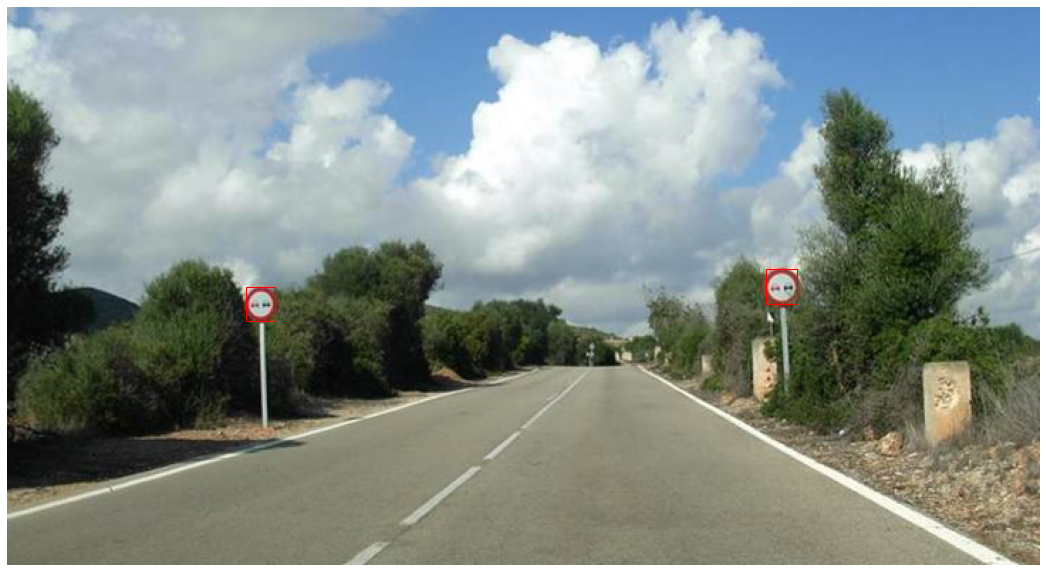

In [46]:
%matplotlib inline

im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()

In [47]:
class ResidualBlock(nn.Module):
    """
    Creates the Residual block of ResNet.
    """
    def __init__(
        self, in_channels, out_channels, use_1x1conv=True, strides=1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        inputs = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.conv3:
            inputs = self.conv3(inputs)
        x += inputs
        return F.relu(x)

In [48]:
def create_resnet_block(
    input_channels,
    output_channels, 
    num_residuals,
):
        resnet_block = []
        for i in range(num_residuals):
            if i == 0:
                resnet_block.append(ResidualBlock(input_channels, output_channels,
                                    use_1x1conv=True, strides=2))
            else:
                resnet_block.append(ResidualBlock(output_channels, output_channels))
        return resnet_block 

In [49]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=157):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block2 = nn.Sequential(*create_resnet_block(16, 32, 2))
        self.block3 = nn.Sequential(*create_resnet_block(32, 64, 2))
        self.block4 = nn.Sequential(*create_resnet_block(64, 128, 2))
        self.block5 = nn.Sequential(*create_resnet_block(128, 256, 2))
        self.linear = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.linear(x)
        return x 

In [50]:
model_c = CustomResNet()
checkpoint = torch.load('./clf9/chkpt_m1c_clf_8.pth', map_location=device)
model_c.load_state_dict(checkpoint)#['model_state_dict'])

<All keys matched successfully>

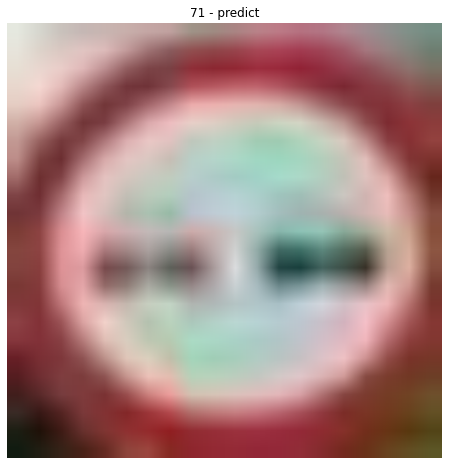

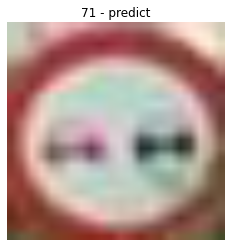

In [51]:
model_c.eval()

figure = plt.figure(figsize=(10, 8))
for i in range(len(boxes)):
    im = Image.open(img_name)
    coordinates = [boxes[i][0], boxes[i][1],
                    boxes[i][2], boxes[i][3]]
    cropped = im.crop(coordinates)
    cropped =  func.resize(cropped, [512,512])
    image = transform(cropped).to(device)
    image = image / 255.
    image = image.unsqueeze(0)
    predict = torch.argmax(model_c(image)).detach().cpu().numpy()
    plt.imshow(cropped)
    plt.title('{} - predict'.format(predict))
    plt.axis("off")
    plt.show()

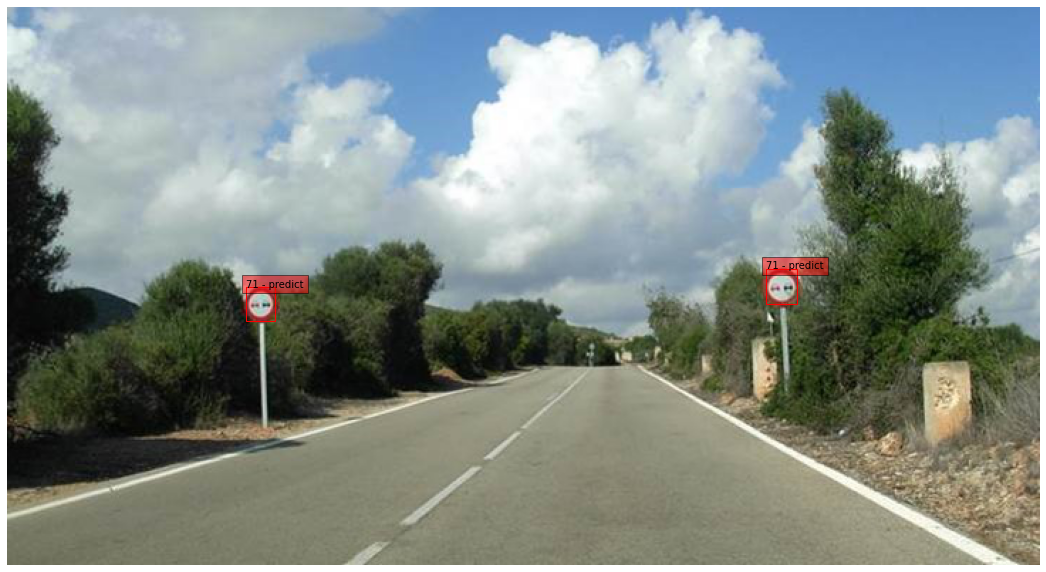

In [52]:
im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
    coordinates = [boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]
    cropped = im.crop(coordinates)
    cropped =  func.resize(cropped, [512,512])
    image = transform(cropped).to(device)
    image = image / 255.
    image = image.unsqueeze(0)
    predict = torch.argmax(model_c(image)).detach().cpu().numpy()
    ax.add_patch(rect)
    plt.text(boxes[i][0], boxes[i][1], '{} - predict'.format(predict), bbox=dict(facecolor='red', alpha=0.5))
    
plt.axis('off')
plt.show()

In [53]:
def predict_d(image, model, device, detection_threshold):
    # transform the image to tensor
    im = transform(image).to(device)
    im = im.unsqueeze(0) # add a batch dimension
    outputs = model(im) # get the predictions on the image
    # get all the predicited class names
#     pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    scores = pred_scores[pred_scores >= detection_threshold].astype(np.float32)
    return boxes, scores#, pred_classes, outputs[0]['labels']

In [54]:
def predict_clf(image, boxes, model, device):
        pred_classes = []
        for i in range(len(boxes)):
            rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
            coordinates = [boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]
            cropped = image.crop(coordinates)
            cropped =  func.resize(cropped, [512,512])
            im = transform(cropped).to(device)
            im = im / 255.
            im = im.unsqueeze(0)
            predict = torch.argmax(model_c(im)).detach().cpu().numpy()
            pred_classes.append(predict)
    
        return pred_classes  

In [55]:
def labls(classes):
    with open('label_map.json') as f:
        data = json.load(f)
        
    key_list = list(data.keys())
    val_list = list(data.values())
    key = []
    for i in classes:
            if i == 156: k = 'Error'
            else: 
                position = val_list.index(i)
                k = key_list[position]
            key.append(k)
    return key

In [56]:
def draw_boxes_rtsd(boxes, scores, classes, image):
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        plt.imshow(image)
        plt.axis('off')
        color = ['r', 'g', 'b', 'c', 'm', 'y', 'w'] * 5
        for i in range(len(boxes)):
            if classes[i] == 'Error': continue
            rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor=color[i], facecolor='none')
            ax.add_patch(rect)
            plt.text(boxes[i][0], boxes[i][1], '{} {:.2f}'.format(classes[i], scores[i]), bbox=dict(facecolor=color[i], alpha=0.5))
        
        return image

In [57]:
img_path = '.'
img_name = '56.jpg'
detection_threshold = 0.5
image = Image.open(img_name)

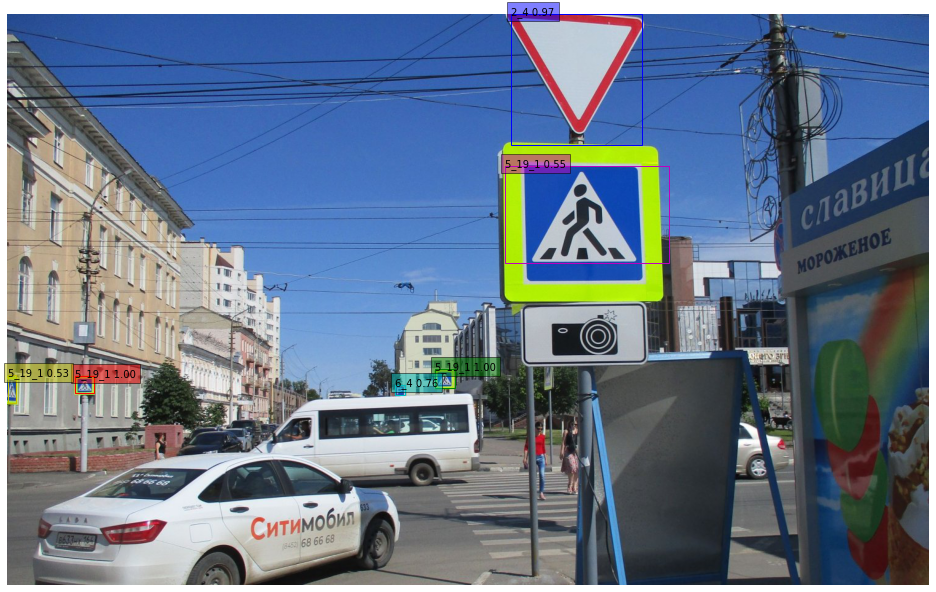

In [58]:
%matplotlib inline
image = Image.open(img_name)
boxes, scores = predict_d(image, modeld2, device, detection_threshold)
classes = predict_clf(image, boxes, model_c, device)
cl = labls(classes)
i = draw_boxes_rtsd(boxes, scores, cl, image)
plt.imshow(i)

In [59]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [60]:
df_val = dataset(".", "val_anno.json")

In [61]:
def distance_to_camera(knownWidth, focalLength, perWidth):
# compute and return the distance from the maker to the camera
       return (knownWidth * focalLength) / perWidth

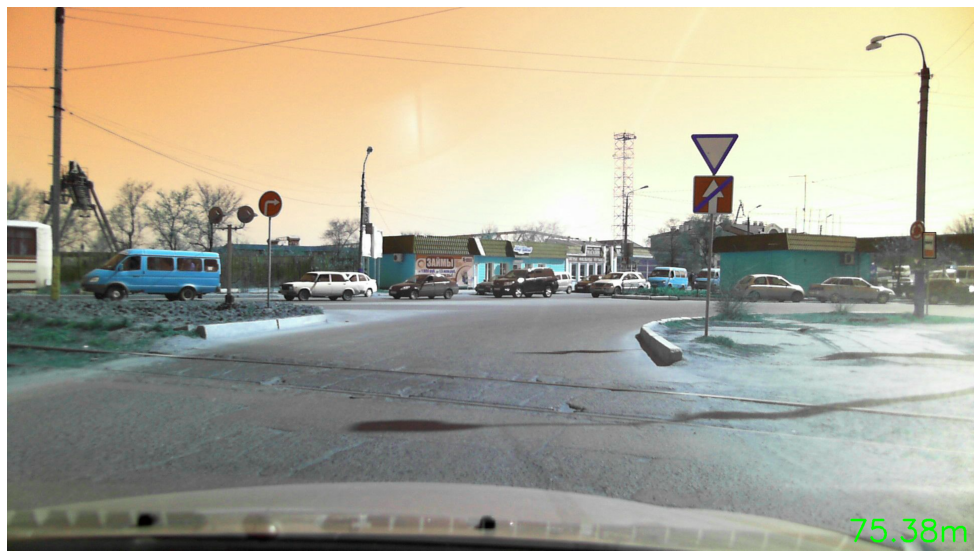

In [62]:
fig = plt.figure(figsize=(18, 10))
r3 = np.random.choice(df_val.file_name)
q = cv2.imread('./' + r3, 1)
im_labels = df_val[df_val.file_name == r3].iloc[0]

inches = distance_to_camera(700, 28, im_labels.bbox[2])

plt.imshow(q)

rect = cv2.rectangle(q,(im_labels.bbox[0], im_labels.bbox[1]), 
                     (im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]), 15)


cv2.putText(q, "%.2fm" % ((inches)/10),
        (q.shape[1] - 250, q.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX,
        2.0, (0, 255, 0), 3)

plt.imshow(rect)
plt.axis("off")
plt.show() 

In [63]:
cap = cv2.VideoCapture('555.mp4')
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
save_name = f"{'555.mp4'.split('/')[-1].split('.')[0]}"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"data/{save_name}.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))
frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

In [64]:
modeld2.eval()
detection_threshold = 0.5

In [65]:
def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image
    # get all the predicited class names
#     pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    return boxes#, pred_classes, outputs[0]['labels']

In [66]:
def draw_boxes1(boxes, classes, labels, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [67]:
def predict_c(image, boxes, model, device):
        pred_classes = []
        image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
        for i in range(len(boxes)):
#             rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
# #             coordinates = [boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]
            cropped = image[boxes[i][1]:boxes[i][3], boxes[i][0]:boxes[i][2]]
            
#             cropped = image.crop(coordinates)
            cropped =  Image.fromarray(cropped)
            cropped =  func.resize(cropped, [512,512])
            im = transform(cropped).to(device)
            im = im / 255.
            im = im.unsqueeze(0)
            predict = torch.argmax(model_c(im)).detach().cpu().numpy()
            pred_classes.append(predict)
    
        return pred_classes  

In [68]:
def draw_boxes(boxes, scores, classes, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
#         color = COLORS[labels[i]]
        color = (0,255,0)
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, '{} {:.2f}'.format(classes[i], scores[i]), (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [69]:
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        # get the start time
        start_time = time.time()
#         with torch.no_grad():
            # get predictions for the current frame
#             boxes, classes, labels = predict(frame, modeld1, device, 0.2)
#             boxes = predict(frame, modeld2, device, 0.2)
        boxes, scores = predict_d(frame, modeld2, device, 0.5)
        classes = predict_c(frame, boxes, model_c, device)
        cl = labls(classes)
        image = draw_boxes(boxes, scores, cl, frame)
        # draw boxes and show current frame on screen
#         image = draw_boxes(boxes, classes, labels, frame)
#         image = draw_boxes(boxes, frame)
        # get the end time
        end_time = time.time()
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        # write the FPS on the current frame
        cv2.putText(image, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2)
        # press `q` to exit
        wait_time = max(1, int(fps/4))
        # convert from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imshow('image', image)
        out.write(image)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    else:
        break

In [70]:
# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Average FPS: 0.111
